# Correlation Exercise – *GPS L1 C/A*

This interactive notebook guides you through the **coarse‑acquisition** step used by every GNSS receiver.  You’ll fill in the missing pieces, run the code, and **acquire a real satellite you recorded**.

## How to work in this notebook
1. **Read the short theory sections**  They recap what the code does. Also recall the presentation slides.
2. **Open each *Task* cell (yellow bar on the left) and replace the `...` with real code or numbers.**  Run the cell *(Shift‑Enter)*.
3. **Run the script cell that follows.**  If something is still missing the script will stop and tell you what.
4. Move on to the next section.

>👉 **Tip 1:** execute the notebook **top‑to‑bottom** the first time so that all variables are visible where the scripts expect them.
>
>👉 **Tip 2:** *Click regularly on the "save to browser storage button" (next to the download button) to not lose your progress.*

# 0. IQ Data and Pre-Processing
This section demonstrates how to transform raw **I/Q** recordings into a cleaned MATLAB `.mat` file that you will load later for the actual acquisition steps.

**You will:**
1. Set the sampling frequency and file path  
2. Read the binary file, format the complex samples  
3. Inspect spectrum, time‑domain traces and amplitude histogram  
4. Save the processed vector as **`IQ_samples.mat`**

Follow the numbered code cells below and execute them in order (⇧ + ⏎).

### 1.  Set Sampling Frequency

In [1]:
% Sampling frequency (Hz)
fs = 4.092e6;  % Enter sampling frequency, e.g. 1.000e6 for 1 MHz

### 2.  Set Data File Path

In [4]:
% Path to I/Q data file
data_file = 'course_IQ_samples_4MHz.dat';  % ← Enter filename, e.g. 'IQ.dat'

### 3.  Load and Format I/Q Samples
Read the binary file, handle interleaved I/Q channels, and remove initial transients.

In [5]:
% === Fixed Parameters ===
fi = 0;                   % Intermediate frequency (Hz)
IsComplex = true;         % True if data is I/Q
Is8Bits = false;          % 8-bit integer format
Is16Bits = false;         % 16-bit integer format
Is32BitsFloat = true;     % 32-bit float format
secondOfData = 1;         % Seconds of data to read
fc = 1575.42e6;          % Center frequency (Hz) for labels
% ========================

% Read binary samples
[fid, errmsg] = fopen(data_file, 'rb');     % binary read

if fid == -1
    fprintf(2, '❌  Unable to open "%s": %s\n', data_file, errmsg);
    return              % Abort this cell early
end
if IsComplex
    if Is16Bits
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'int16');
    elseif Is8Bits
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'int8');
    else
        [raw, ~] = fread(fid, 2*secondOfData*fs, 'float32');
    end
    data = raw(1:2:end) + 1i*raw(2:2:end);
else
    if Is16Bits
        [data, ~] = fread(fid, secondOfData*fs, 'int16');
    elseif Is8Bits
        [data, ~] = fread(fid, secondOfData*fs, 'int8');
    else
        [data, ~] = fread(fid, secondOfData*fs, 'float32');
    end
end
fclose(fid);

% Remove initial transient samples
if length(data) > 1e6
    data(1:1e6) = [];
end

### 4.  Power Spectral Density
Use Welch's method to estimate PSD and plot it. Frequency axis is in MHz.
https://en.wikipedia.org/wiki/Welch%27s_method     <br><br>
**Questions:**<br>
What do you see? <br> 
Is the Spectrum according to your expectation?

➡️  [PSD]  Starting Welch PSD estimate …
   ✓  Loaded Octave-Forge package: signal
   ✓  PSD computed with pwelch()


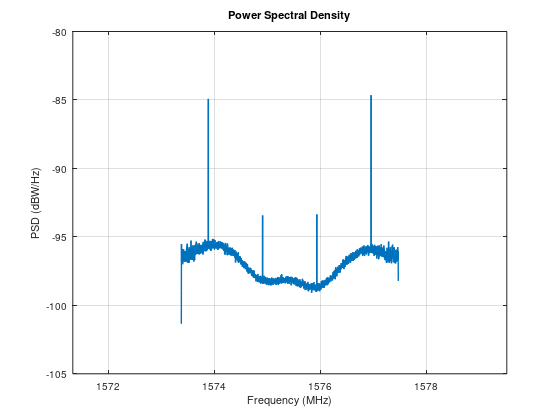

✅  [PSD]  Finished and plotted.


In [6]:
disp("➡️  [PSD]  Starting Welch PSD estimate …");

% ------------------------------------------------------------
% 1. Make sure the Octave-Forge “signal” package is available
% ------------------------------------------------------------
has_signal = false;
try
    % does "signal" appear in the installed-package list?
    pkgs = pkg("list");
    for k = 1 : numel(pkgs)
        if strcmp(pkgs{k}.name, "signal")
            has_signal = true;
            break
        end
    end
catch
    % pkg() itself not found (rare)
end

if has_signal
    try
        pkg load signal
        disp("   ✓  Loaded Octave-Forge package: signal");
    catch ME
        has_signal = false;
        fprintf(2,"   ⚠️  Could not load 'signal' package (%s). Falling back to naive PSD.\n", ME.message);
    end
else
    fprintf(2,"   ⚠️  Package 'signal' not installed. Falling back to naive PSD.\n");
end

% ------------------------------------------------------------
% 2. Compute PSD
% ------------------------------------------------------------
if has_signal
    [pw, f] = pwelch(data, [], [], [], fs);    % Welch method
    disp("   ✓  PSD computed with pwelch()");
else
    % --- simple rectangular window periodogram as a fallback ---
    Nfft  = 4096;
    win   = hanning(Nfft);                     % a little windowing to reduce leakage
    S     = fftshift( fft( data(1:Nfft) .* win.' , Nfft ) );
    pw    = (abs(S).^2) / (fs * sum(win.^2));
    f     = linspace(-fs/2, fs/2, Nfft);
    disp("   ✓  PSD computed with naive FFT method");
end

% ------------------------------------------------------------
% 3. Plot
% ------------------------------------------------------------
figure;
if IsComplex
    plot((fc+f-f(length(f))/2)/1e6, 10*log10(pw), 'LineWidth', 1);
    xlim([(fc-fs)/1e6 (fc+fs)/1e6]);
else
    plot(f/1e6,          10*log10(pw), 'LineWidth', 1);
end
grid on;
xlabel('Frequency (MHz)');
ylabel('PSD (dBW/Hz)');
title('Power Spectral Density');

disp("✅  [PSD]  Finished and plotted.");


### 5.  Time‑Domain View
Visualize the first 100,000 samples of the real and imaginary parts.

➡️  [TD]  Plotting real & imaginary parts …
   ✓  Using first 100000 samples for the snapshot.


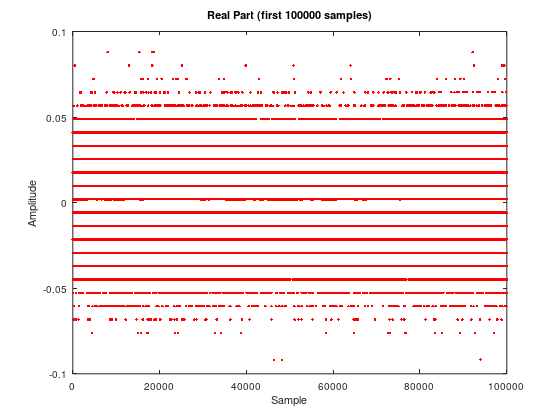

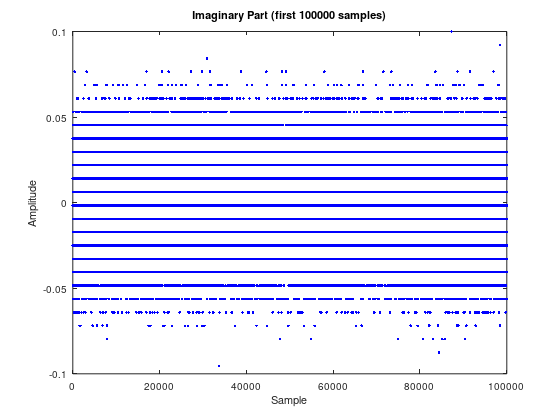

✅  [TD]  Finished plotting time-domain snapshots.


In [7]:
disp("➡️  [TD]  Plotting real & imaginary parts …");

% ------------------------------------------------------------
% 1. Decide how many samples we can safely show
% ------------------------------------------------------------
if numel(data) < 1e5
    nplot = numel(data);
    fprintf(2, "   ⚠️  Only %d samples available – plotting all of them.\n", nplot);
else
    nplot = 1e5;
    fprintf("   ✓  Using first %d samples for the snapshot.\n", nplot);
end

% ------------------------------------------------------------
% 2. Real component
% ------------------------------------------------------------
figure;
plot(real(data(1:nplot)), 'r.');
xlabel('Sample');  ylabel('Amplitude');
title(sprintf('Real Part (first %d samples)', nplot));

% ------------------------------------------------------------
% 3. Imaginary component
% ------------------------------------------------------------
figure;
plot(imag(data(1:nplot)), 'b.');
xlabel('Sample');  ylabel('Amplitude');
title(sprintf('Imaginary Part (first %d samples)', nplot));

disp("✅  [TD]  Finished plotting time-domain snapshots.");


### 6. Histogram of Real and Imaginary Component
Plot the amplitude distribution to check for clipping or quantization.

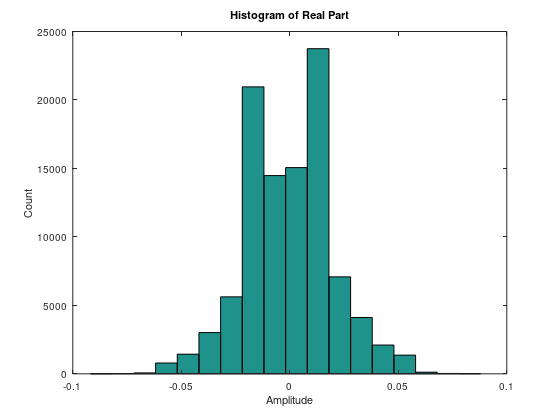

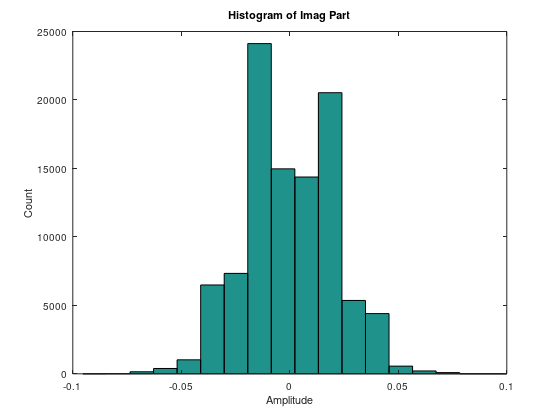

In [8]:
figure;
hist(real(data(1:1e5)), 18);
xlabel('Amplitude');
ylabel('Count');
title('Histogram of Real Part');

figure;
hist(imag(data(1:1e5)), 18);
xlabel('Amplitude');
ylabel('Count');
title('Histogram of Imag Part');

### 7.  Save Processed Data

In [9]:
% Save to MAT-file
save('IQ_samples4MHz.mat', 'data');
disp('✅ Data saved to IQ_samples.mat');
disp('✅ Check in the left sidebar, you should find the .mat file there');

✅ Data saved to IQ_samples.mat
✅ Check in the left sidebar, you should find the .mat file there


# 1. Common Helper Functions

Below are the three MATLAB/Octave functions that every GNSS acquisition routine needs.

* **`CodeAcquisition`** – builds a 2‑D delay/Doppler search space using an FFT‑based correlation technique.
* **`NoiseVarianceEstimator`** – estimate of the noise floor .
* **`InverseChiSquarePfa`** – finds the chi-square threshold (Th) such that its upper-tail probability equals the target false alarm probability (PfaT).

🔍 ***Where you still need to work*** – The first function contains *TODO* markers so you can practise the maths behind the FFT acquisition.

### ✍️ **`CodeAcquisition`**  *Complete me!*
This function is extracts the signal out of the noise by performing the correlation between the collected signal samples and the replical of the GNSS signal.<br>
<img src="figures/correlation_equations.png" width="800"/> <br><br>
**Correlation process for a sequence of 28 chips** (for illustration purposes only - C/A code has 1023 chips and thus its correlation properties are much better).<br>
<video controls src="figures/myCorrVideo.mp4" width="800" /><br><br>
**Correlation of a GPS C/A PRN sequence (Autocorrelation)**
<img src="figures/CA_ACF.png" width="800"/> <br><br>


**Correlation of a GPS C/A PRN sequence (Autocorrelation)**<br>
<img src="figures/CA_ACF.png" width="800"/> <br><br>
1. **Normalize frequencies**
   Convert the IF (`fi`) and Doppler offsets into fractions of the sampling rate so everything works in normalized units.

3. **Pre-calculate the Complex Conjugate of the FFT of the Replica** (conj(FFT(y) in the equation above)
   Compute `F_rep = __________?` once and re-use it when scanning through all Doppler bins

4. **Loop over Doppler bins**
   For each Doppler hypothesis, shift your signal samples by the Doppler offset frequency that you are testing, i.e. multiply with `exp(–2jπ·f_{Doppler})`, FFT it, multiply by `F_rep` (i.e. correlate), then IFFT back to get correlation function in the time domain.

5. **Form the detection metric**
   Take the magnitude-squared of each complex correlation to fill out the final `sspace` matrix, which you can then search for peaks.
6. **Your Task** : Fill in the missing line 26 to compute the frequency-domain matched filter for the code replica.
    > *Hint: Use the FFT and complex conjugate of the replica*


In [10]:
function sspace = CodeAcquisition(signal, rep, Nc, Doppler_vec, fs, fi)
% CodeAcquisition  Evaluate the search space for code acquisition using
%                  a time-domain FFT technique
%
% Syntax:
%   sspace = CodeAcquisition(signal, rep, Nc, Doppler_vec, fs, fi)
%
% Inputs:
%   signal      [1×N]     Galileo/GPS input signal (with Doppler shift,
%                         code delay, noise, etc.)
%   rep         [1×Nc]    Local code replica
%   Nc          integer   Length of the local code replica
%   Doppler_vec [1×M]     Vector of Doppler offsets (Hz)
%   fs          scalar    Sampling frequency (Hz)
%   fi          scalar    Intermediate frequency (Hz)
%
% Output:
%   sspace      [M×N]     Search-space matrix (correlation magnitudes)

    % Normalize frequencies
    fif           = fi / fs;
    Doppler_norm  = Doppler_vec / fs;

    % TODO
    % Precompute FFT of the local replica
    F_rep = conj(fft(rep));

    % Time index vector
    N = size(signal, 2);
    t = 0:(N - 1);

    % Allocate output
    sspace = zeros(length(Doppler_norm), N);

    % Loop over all Doppler bins
    for i = 1:length(Doppler_norm)
        fc    = fif + Doppler_norm(i);
        % Mix the input down to baseband for this Doppler bin
        IQ    = exp(-2j * pi * fc .* t) .* signal;
        % FFT of the mixed signal
        X     = fft(IQ);
        % Frequency-domain correlation via multiplication
        sspace(i, :) = ifft(X .* F_rep);
    end

    % Convert to real magnitude-squared values
    sspace = real(sspace .* conj(sspace));
end

### ▶ **`NoiseVarianceEstimator`**
This function estimates the noise variance in `y` by:

1. **Random code**
   Create a bipolar (±1) sequence whose length matches the data duration (`clen`).

2. **Upsample**
   Stretch that code to the full sampling rate (`fs`) so it aligns with `y`.

3. **Correlate**
   Run one Doppler‐free correlation of `y` against this “noise” code via `CodeAcquisition`.

4. **Decimate**
   Pick every `fs/fc`-th correlator output to obtain roughly independent noise samples.

5. **Compute variance**
   Take the mean of those samples and divide by 2 → your noise‐variance estimate `sigma_est`.

In [11]:
function sigma_est = NoiseVarianceEstimator( y, fs, fc )

% Arguments:
%   y :         [vector] contains the input samples
%   fs:         [scalar] sampling frequency
%   fc:         [scalar] code rate

%
% Returns:
%   sigma_est:     [scalar] the estimated noise variance
%%

% First generate a fictitious code
clen = round( length( y ) / fs * fc );
code =  sign( rand( 1, clen ) - 0.5 );      % A bipolar random code usually has
                                            % good correlation properties

% Resample the code
loc = reshape(repmat(code,fs/fc,1),1,fs/fc*size(code,2));

% Now compute the correlators (for a single Doppler value is enough )
correlators = CodeAcquisition( y, loc, 1, 0, fs, 0 );


% Down-sample them to get uncorrelated values:
step = round( fs / fc );
correlators = correlators(1:step:end);

% Finally the noise variance estimate
sigma_est = mean( correlators ) / 2;


### ▶ **`InverseChiSquarePfa`**
This routine finds the χ²–distribution threshold `Th` for `K` degrees of freedom that yields a target false‐alarm rate `PfaT`.

In [12]:
function Th = InverseChiSquarePfa( K, PfaT )

Th = -2*log( PfaT );

Niter = 1000;
Pfa = 0;
ii = 1;

fact = factorial( K - 1 );

while abs( PfaT - Pfa ) > 1e-3 * PfaT,

    Pfa = gammainc( Th / 2, K, 'upper' );					% Compute the ccdf
    pdf = exp( -Th / 2 ) .* ( Th / 2 ).^( K - 1 ) / fact;	% Compute the pdf

    Th = Th + ( Pfa - PfaT )/ pdf;

    ii = ii + 1;
    if ii > Niter,
        break;
    end
    
end

# 2. GPS L1 C/A acquisition

**Goal:** detect a legacy GPS C/A code.

Two open tasks:
1. *Task&nbsp;P1* – up‑sample the C/A PRN replica to the 2.046 MHz sample rate.
2. *Task&nbsp;P2* – build a Doppler search vector covering ±10 kHz.

When you’re done, run `Acquire GPS C/A` section to execute the search.

### ▶ Initialisation - Run section and use these variables for Task P1 and P2

Key aspects of this section: <br>
- load the I/Q samples stored earlier in the `.mat` file
- load GPS C/A Code PRN sequences. Every GPS satellites has a unique PRN code sequence for every signal component like the C/A code <br>
  . C/A PRN code has a length of 1023 bits <br>
  . C/A Code modulation is BPSK(1) - Binary Phase Shift Keying with a chip rate of 1.023 MHz <br>
- define the coherent integration time - below it is specified with 5 ms - you may want to experiment with it
- PRN code is repeated (w/o changing the sampling rate) to align start forming the replica. The PRN code replica needs to align to the coherent integration time.

In [18]:
%=========================================================================%
% Load the prepared IQ samples                                            %
%=========================================================================%
load IQ_samples4MHz.mat

%=========================================================================%
% Load the PRN  code                                                      %
%=========================================================================%

load gps_ca_codes.mat;

%=========================================================================%
% Initialise                                                              %
%=========================================================================%


fi = 0;
fc = 1.023e6; % GNSS signal chip rate
fs = 4.092e6; % Sample rate
Tcoh = 5e-3; % Coherent Integration time [ms]
T_primary_code = 1e-3; %Period of the primary code [ms]
N_noncoh = 1; %Number of non-coherent accumulations
Tdwell = Tcoh *N_noncoh; %Total Dwell time [ms]
Nsample = Tcoh * fs; %Number of signal samples in Coherent Integration Period

PRN = repmat(gps_ca,1,round(Tcoh/T_primary_code));

### ✍️ Task P1 - *Up-sample the GPS C/A Code*
Build the matrix `Rep` so that each row `i` contains the up-sampled replica for PRN `i`.

**Remember:**

 - The GPS C/A is a BPSK(1), i.e. a signal at a rate of 1.023 MHz
 
 - The recorded signal is sampled at a rate of 2.046 MHz

**What you need to do:**

Up-sample the C/A code replica to 2.046 MHz, i.e. repeat every chip of the C/A code replica 2 times. 

<img src="figures/upsample.png" width="800"/>

> *Hint: You can use the functions repmat and reshape to repeat every sample twice (1.023 → 2.046 MHz) (ref. homework)*

In [19]:
for i=1:size(PRN,1)

    Rep(i, :) = reshape(repmat(PRN(i,:) , 4, 1), 1, 4*size(PRN,2));

end

### ✍️ Task P2 - *Doppler Search Vector*
**Important to know**, Doppler range for a GNSS signal in L-Band and a static user on ground can be within -10/+10 kHz (with good margin) <br>

Create a row vector `Doppler_vec` that goes from -10 kHz to +10kHz with a 0 value in the center. <br>
For the Doppler increment you can follow the rule of thumb: 
$$\Delta f_{Doppler} = \frac{2}{3\cdot T_{dwell}} [Hz]$$
with
$$T_{dewell} = T_{coh} \cdot N_{non-coherent} [s]$$
We are using a coherent Integraction time $T_{coh}$ of 5 ms and no non-coherent accumulation.




**What you need to do:**

Build up a vector (single row, N columns) that ranges from `-Doppler_range` in steps of `Doppler_step` up to `+Doppler_range`.
 <br><br>
<img src="figures/Doppler_Vector.png" width="800"/>
> For symmetry purposes it is good to center around 0 Hz, you do **not** need to match exactly +/- 10 kHz on the lower/upper limit

In [20]:
Doppler_range = 10e3 ;
Doppler_step = round(2/(3*Tdwell));

Doppler_vec = [Doppler_step: Doppler_step: Doppler_range];
Doppler_vec = [-fliplr(Doppler_vec) 0 Doppler_vec];

### ▶ **`Acquire GPS C/A`** *Run after tasks P1 and P2*

This function performs the acquistion of the GPS C/A code signal, i.e. this function is
1. Testing for several GPS C/A codes whether the code can be acquired within the collected signal samples, i.e. whether it can be extracted out of the noise
2. Calling the `CodeAcquisition` function
3. Testing whether the energy extracted (i.e. the correlation maximum) is sufficient to declare successful acquisisition. For this decision logic with Probability of False Alarm is established.
4. In case the correlation maximum is exceeding the test threshold, acquisition is declared and you get <br>
    . Information which PRN has been acquired<br>
    . Information about Code Delay and Doppler Frequency Offset<br>
    . Plot of the Acquisition Matrix<br>
    . Acquisition Search Space results are stored in a .mat file (sspace_PRNxxx.mat)<br>

code select: 1   304.792801   367.022701
code select: 2   294.647302   370.936429
code select: 3   302.156231   379.441368
code select: 4   301.427337   380.704715
code select: 5   1573.320330   377.713516
PRN 5 acquired, Doppler [Hz]: -1995.000000, Code Delay [samples]: 2893


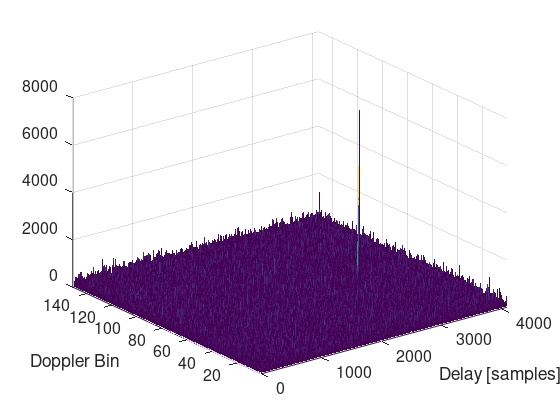

code select: 6   285.724822   389.211918
code select: 7   633.958017   371.119329
PRN 7 acquired, Doppler [Hz]: 3059.000000, Code Delay [samples]: 899


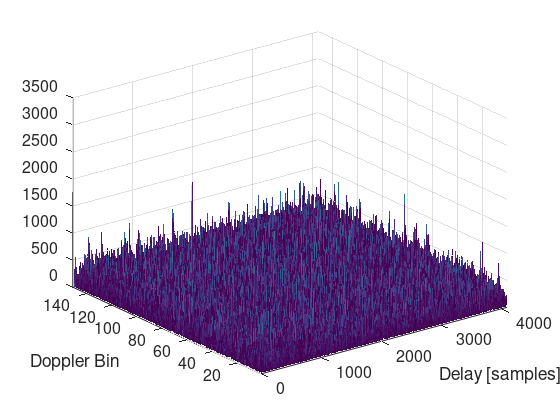

code select: 8   1123.859371   376.204698
PRN 8 acquired, Doppler [Hz]: 4123.000000, Code Delay [samples]: 5211


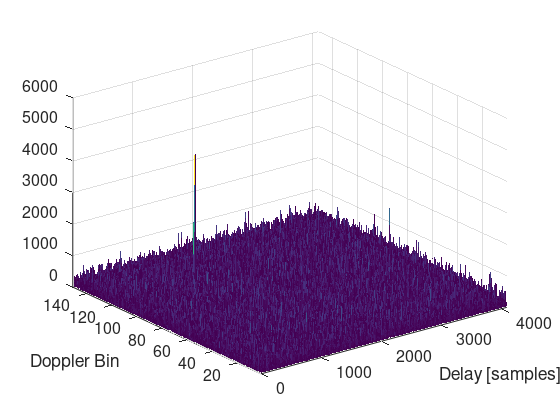

code select: 9   286.655451   380.772401
code select: 10   362.820214   380.672897
code select: 11   303.088269   377.235158
code select: 12   272.035620   377.509158
code select: 13   312.510110   383.375793
code select: 14   278.796648   380.004793
code select: 15   294.768041   380.012958
code select: 16   1653.353035   377.067918
PRN 16 acquired, Doppler [Hz]: 1197.000000, Code Delay [samples]: 10


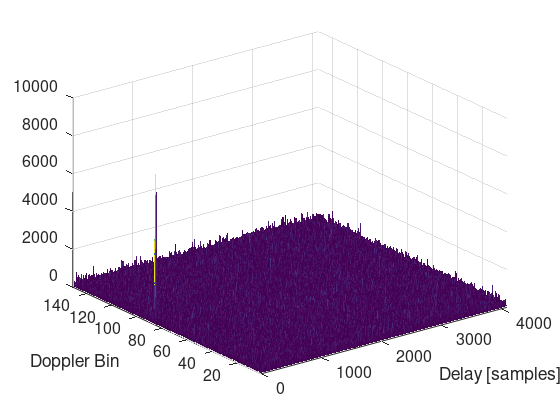

code select: 17   307.524903   374.959378
code select: 18   2674.631877   381.483095
PRN 18 acquired, Doppler [Hz]: -399.000000, Code Delay [samples]: 684


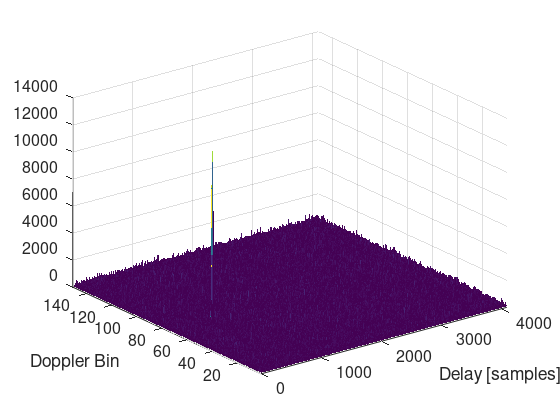

code select: 19   290.206476   378.048422
code select: 20   269.112430   373.852191
code select: 21   270.078352   371.231289
code select: 22   265.745665   390.741866
code select: 23   1145.322620   380.502134
PRN 23 acquired, Doppler [Hz]: 3458.000000, Code Delay [samples]: 2036


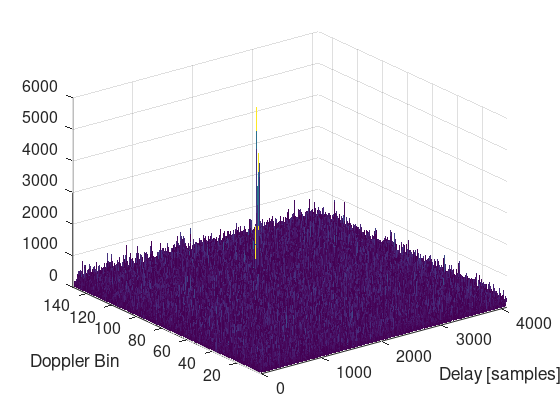

code select: 24   300.668637   372.128399
code select: 25   266.816452   376.639682
code select: 26   4212.167282   377.403943
PRN 26 acquired, Doppler [Hz]: -1197.000000, Code Delay [samples]: 1277


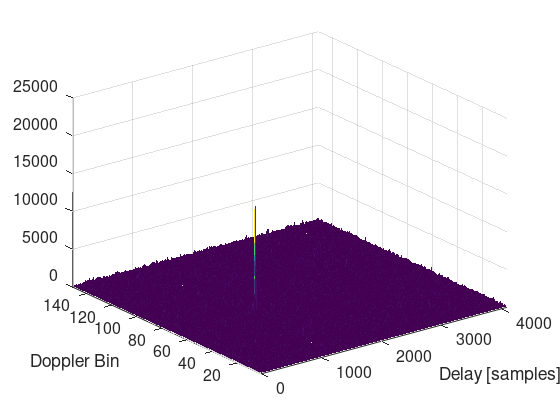

code select: 27   1483.202025   375.173313
PRN 27 acquired, Doppler [Hz]: 3325.000000, Code Delay [samples]: 1342


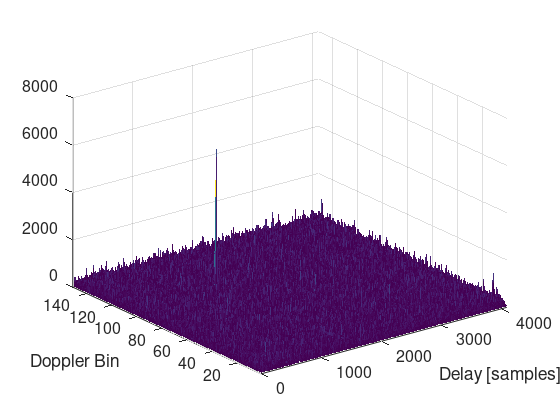

code select: 28   333.634934   378.139298
code select: 29   321.646611   375.203760
code select: 30   279.466594   382.221589


fatal: caught signal Aborted -- stopping myself...

In [23]:
% Sanity checks
assert(exist('Rep','var') && exist('Doppler_vec','var'), '❌ Run Task P1/P2 first');

%=========================================================================%
% Search over all possible PRN sequences                                  %
%=========================================================================%
for code_select = 1:30

    Rep_search = Rep(code_select,:);
    
    Nc = round(Tcoh/1e-3)*fs/1e3;
    sspace = 0;
    
    for ii = 1:N_noncoh
    
        y =  data( (ii - 1) * Nc + (1:Nc) ).';   % use just 1 period of signal at the time
    
        % Compute the search space for a single coherent integration epoch
        Tsspace = CodeAcquisition( y, Rep_search, Nc, Doppler_vec, fs, fi);
        sspace = sspace + Tsspace;  % Non-coherently accumulate the results

    end

    %=========================================================================%
    % Decision Logic                                                          %
    %=========================================================================%
    Pfa_global = 0.01;
    %Pfa_cell = 1-(1-Pfa_global).^(1/numel(sspace));
    Pfa_cell = Pfa_global/numel(sspace)*2;
    
    Th = InverseChiSquarePfa(N_noncoh, Pfa_cell);
    sigma_est = NoiseVarianceEstimator(y, fs, fc);
    Th = sigma_est * Th;
    
    sspace_single_period = reshape(sspace,[size(sspace,1),fs/fc*size(PRN,2)/(Tcoh*1e3),Tcoh*1e3]);
    sspace_single_period = squeeze(sum(sspace_single_period,3));

    fprintf('code select: %i   %f   %f\n',code_select, max(max(sspace)), Th);
    
    if (max(max(sspace)) > Th)
    
            [doppler_id, delay_id] = find(sspace == max(max(sspace)));
            fprintf('PRN %i acquired, Doppler [Hz]: %f, Code Delay [samples]: %i\n',code_select, Doppler_vec(doppler_id(1)), delay_id(1));
            figure
            surf( sspace_single_period, 'EdgeColor', 'none');
            set( gca, 'FontSize', 16)
            xlabel('Delay [samples]');
            ylabel('Doppler Bin');
            xlim([0 size(sspace_single_period,2)]);
            ylim([1 length(Doppler_vec)])
            output_file = ['sspace_PRN',num2str(code_select,'%i'),'.mat'];
            save(output_file, 'sspace', 'Doppler_vec');
    end


end

### ✍️ Task P3 - <i>Plot for your first acquired signal the Correlation Main Peak </i>

What you need to do:
1. load the `.mat` file containing the search space of a successfully acquired code (`sspace_PRNxxx.mat`)
2. Recall from above the Doppler Frequency offset
3. Find the index of the Doppler Frequency offset in the vector `Doppler_vec`
4. Plot the corresponding row of `sspace`



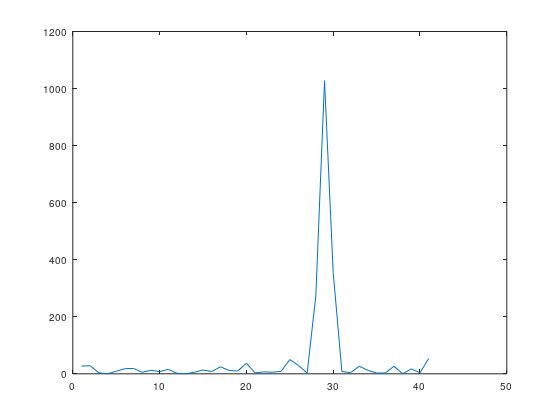

In [10]:
load sspace_PRN5.mat
ind = find(Doppler_vec == -1330);
figure; plot(sspace(ind,1660:1700))